APPLIED DATA SCIENCE CAPSTONE NOTEBOOK

Business Problem:

This project will attempt to help a client looking to expand their retail business into Copenhagen. The client is a high-end cafe and roastarie which also bakes and sells their own pastries. They currently have a small but strong business in the US and are looking to expand their presence, possibly internationally. 

My goal is to provide them with some insights to help them focus their expansion and understand where in Copenhagen they should scout for locations. I plan to look at which neighborhoods have the highest concentration of coffee shops and cafes and where they might have a particular opportunity. I will look at distance to the city center and any other characteristics that might pop up during the exploration. 

Data to be used: 

I have compiled some data on Copenhagen from a few websites. The names of the neighborhoods are from google searches and wikipedia. GPS coordinates for the neighborhoods I got from latitude.to. Since I live in Copenhagen I was able to correct or guide the locations a bit to better capture the neighborhoods. Unfortunately, I was not able to find any data to scrape so I had to input all the locations manually.

Venue data was all collected from Foursquare through their API the same way we did in the other exercises. 

In [101]:
import pandas as pd
import numpy as np

import requests
import json 

from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import geocoder # import geocoder

print('Libraries imported.')

Libraries imported.


In [50]:
cph_df = pd.DataFrame({'District':['Indre By','Indre By','Indre By','Indre By','Indre By','Vesterbro/Kongens Enghave',
                              'Nørrebro','Nørrebro','Østerbro','Østerbro','Amager Øst','Amager Øst','Amager Vest',
                              'Valby','Bispebjerg','Vanløse','Brønshøj-Husum','Brønshøj-Husum','Fredriksberg'],
                  'District Population':[55493,55493,55493,55493,55493,67844,80572,80572,79276,79276,57673,57673,71755,56274,
                                        55239,40843,44741,44741,103960],
                  'Neighborhood':['Christianshavn','Kongens Nytorv','Nørreport','Fredriksstaden','Fredriksholm/Nyholm',
                                 'Kødbyen/Saxopark','Køpenhavn N','Nørrebro','Trianglen','Køpenhavn Øst','Amagerbro',
                                 'Sundbyøster','Sundby','Valby','Nordvest','Vanløse','Brønshøj','Husum','Fredriksberg C'],
                  'Latitude':[55.67358,55.67837,55.68345,55.68693,55.68346,55.67033,55.68967,55.69645,55.69937,55.70934,
                             55.66562,55.65455,55.63772,55.66166,55.70865,55.69117,55.70387,55.71015,55.67567],
                  'Longitude':[12.59325,12.58358,12.56908,12.58702,12.60662,12.55717,12.55585,12.54561,12.57750,12.57716,
                              12.60095,12.61739,12.58295,12.51678,12.53185,12.48118,12.49922,12.47079,12.54501]})
cph_df

,District,District Population,Neighborhood,Latitude,Longitude
0,Indre By,55493,Christianshavn,55.67358,12.59325
1,Indre By,55493,Kongens Nytorv,55.67837,12.58358
2,Indre By,55493,Nørreport,55.68345,12.56908
3,Indre By,55493,Fredriksstaden,55.68693,12.58702
4,Indre By,55493,Fredriksholm/Nyholm,55.68346,12.60662
5,Vesterbro/Kongens Enghave,67844,Kødbyen/Saxopark,55.67033,12.55717
6,Nørrebro,80572,Køpenhavn N,55.68967,12.55585
7,Nørrebro,80572,Nørrebro,55.69645,12.54561
8,Østerbro,79276,Trianglen,55.69937,12.57750
9,Østerbro,79276,Køpenhavn Øst,55.70934,12.57716


In [17]:
address = 'Copenhagen, Denmark'

geolocator = Nominatim(user_agent="Tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The coordinates of Copenhagen are {latitude}, {longitude}.')

The coordinates of Copenhagen are 55.6867243, 12.5700724.


In [51]:
# Let's start by creating a map of Copenhagen and with our neighborhoods just to get a feel of the city.

map_cph = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, district, neighborhood in zip(cph_df['Latitude'], cph_df['Longitude'], cph_df['District'], cph_df['Neighborhood']):
    label = f'{neighborhood}, {district}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cph)  
    
map_cph

In [21]:
CLIENT_ID = 'JWEGW0PLMO4CD2YY4US5NK2L4H0OHNIRSMQMLCVARAD3RHVB' # your Foursquare ID
CLIENT_SECRET = 'HJI2JG0BY55NF4ADINDEBD441ENQW2QL3BNY2HD15RZJ13H0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JWEGW0PLMO4CD2YY4US5NK2L4H0OHNIRSMQMLCVARAD3RHVB
CLIENT_SECRET:HJI2JG0BY55NF4ADINDEBD441ENQW2QL3BNY2HD15RZJ13H0


In [190]:
# Next let's get our venue data from Foursquare

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

# function gets the top 100 venues in a 600 meter radius. We populater a set then cast to a list to ensure we have unique 
# venues in case of overlap.

limit=100

def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=list(set())
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [191]:
# Get the venues from Foursquare
cph_venues = getNearbyVenues(names = cph_df['Neighborhood'], 
                                 latitudes = cph_df['Latitude'], 
                                 longitudes = cph_df['Longitude'])

Christianshavn
Kongens Nytorv
Nørreport
Fredriksstaden
Fredriksholm/Nyholm
Kødbyen/Saxopark
Køpenhavn N
Nørrebro
Trianglen
Køpenhavn Øst
Amagerbro
Sundbyøster
Sundby
Valby
Nordvest
Vanløse
Brønshøj
Husum
Fredriksberg C


In [746]:
# Let's let's see how many unique venues and different categories we have.
print('There are {} unique categories.'.format(len(cph_venues['Venue Category'].unique())))
print(cph_venues.shape)

There are 181 unique categories.
(1042, 7)


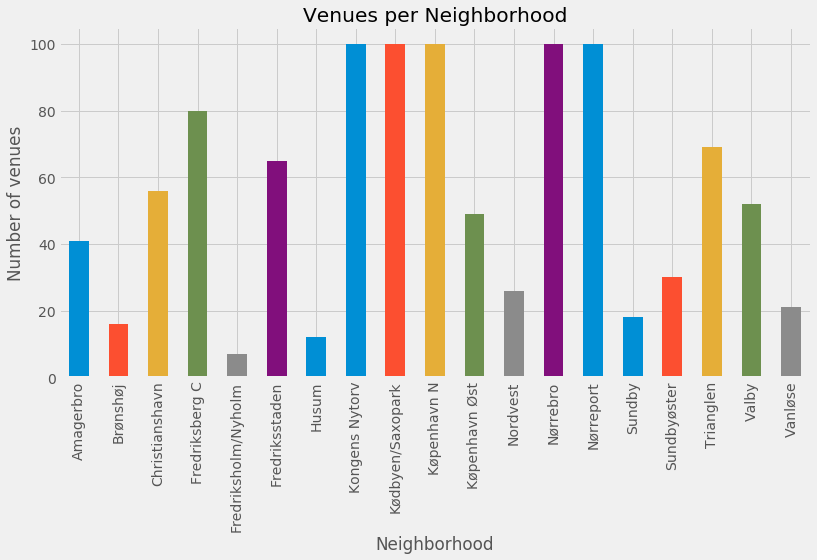

In [747]:
# Let's see how many venues we have in each neighborhood. It looks like 5 neighborhoods maxed out the search limit so they 
# even contain more venues.
cph_venues.groupby('Neighborhood').count()['Venue Category'].plot(kind='bar', figsize=(12, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Venues per Neighborhood') # add title to the plot

plt.show()

Let's take a look at coffee shops and cafes. Bakeries could also be considered a competitor. Our client also serves fresh pastries and many bakeries serve coffee and provide a cafe experience. Let's include bakeries with our cafes and coffee shops.

In [448]:
# We create a new dataframe with the bakeries, cafes, and coffee shops.

coffee_df = cph_venues[cph_venues['Venue Category'].isin(['Café','Coffee Shop','Bakery'])].reset_index()
coffee_df.drop('index',axis=1,inplace=True)
print(coffee_df.shape)
coffee_df.head()

(162, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Christianshavn,55.67358,12.59325,Lagkagehuset,55.672591,12.591361,Bakery
1,Christianshavn,55.67358,12.59325,Parterre Christianshavn,55.675427,12.596172,Café
2,Christianshavn,55.67358,12.59325,Kafferiet,55.673096,12.589928,Coffee Shop
3,Christianshavn,55.67358,12.59325,Sweet Treat,55.674203,12.590997,Café
4,Christianshavn,55.67358,12.59325,The Organic Boho,55.671896,12.593272,Café


In [554]:
# Quick look at the number of venues per neighborhood

coffee_df.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Dist from center
Neighborhood,,,,,,,
Amagerbro,7,7,7,7,7,7,7
Brønshøj,4,4,4,4,4,4,4
Christianshavn,10,10,10,10,10,10,10
Fredriksberg C,10,10,10,10,10,10,10
Fredriksholm/Nyholm,1,1,1,1,1,1,1
Fredriksstaden,10,10,10,10,10,10,10
Kongens Nytorv,10,10,10,10,10,10,10
Kødbyen/Saxopark,9,9,9,9,9,9,9
Køpenhavn N,21,21,21,21,21,21,21


In [595]:
# It could also be interesting to look at the distance from the city center and see if that tells us anything about where 
# the best prospective locations could be.

import math

def calc_dist(lat2, lon2):
    """
    Calculate distance between two points using 
    latitude and longitude. Function returns 
    distance in km.
    """
    lat1, lon1, lat2, lon2 = map(math.radians, [55.67358, 12.59325, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    km = 6367 * c
    return '%.2f' % km

# calculate distance from city center (Indre By)
Dist_to_center = []

for index,row in coffee_df.iterrows():
    
    lon2 = row['Venue Longitude']
    lat2 = row['Venue Latitude']
    
    Dist_to_center.append(float(calc_dist(lat2, lon2)))
    
print(Dist_to_center)

[0.16, 0.28, 0.22, 0.16, 0.19, 0.43, 0.51, 0.54, 0.39, 0.6, 0.83, 0.99, 1.0, 1.1, 1.1, 1.01, 1.07, 0.6, 1.03, 1.16, 1.85, 2.07, 2.03, 1.85, 1.85, 1.62, 1.57, 2.02, 1.95, 1.47, 1.81, 1.49, 1.65, 1.51, 2.05, 1.61, 1.64, 1.51, 1.67, 1.74, 1.61, 2.22, 1.16, 1.49, 1.09, 1.18, 1.57, 1.58, 1.14, 1.33, 1.46, 1.27, 1.59, 2.3, 2.32, 2.59, 1.93, 2.4, 2.31, 2.7, 2.8, 2.72, 2.93, 2.93, 3.03, 2.93, 3.11, 2.88, 2.83, 2.62, 2.57, 2.63, 2.62, 2.79, 3.14, 2.8, 2.8, 2.46, 2.45, 2.62, 2.46, 2.59, 2.41, 3.94, 3.9, 3.95, 3.9, 3.65, 3.65, 4.41, 3.6, 4.18, 3.94, 3.7, 3.89, 3.89, 3.67, 3.68, 3.6, 3.07, 2.94, 2.88, 3.03, 3.24, 2.71, 2.58, 3.09, 3.18, 3.3, 2.59, 2.79, 2.74, 2.57, 3.99, 3.69, 3.59, 4.33, 3.73, 3.72, 3.7, 4.48, 3.6, 0.99, 1.27, 1.23, 1.29, 1.29, 1.12, 1.04, 2.32, 2.61, 2.19, 2.86, 2.88, 4.88, 5.0, 4.97, 5.2, 5.02, 5.19, 5.15, 5.12, 5.72, 5.15, 5.27, 5.36, 5.43, 5.35, 6.89, 6.74, 6.63, 6.83, 3.0, 3.1, 3.13, 2.72, 2.7, 2.62, 2.73, 3.0, 2.93, 2.69]


In [646]:
# Let's add the distance information to our data set

coffee_df['Dist from center'] = Dist_to_center
coffee_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Dist from center
0,Christianshavn,55.67358,12.59325,Lagkagehuset,55.672591,12.591361,Bakery,0.16
1,Christianshavn,55.67358,12.59325,Parterre Christianshavn,55.675427,12.596172,Cafe/Coffee Shop,0.28
2,Christianshavn,55.67358,12.59325,Kafferiet,55.673096,12.589928,Cafe/Coffee Shop,0.22
3,Christianshavn,55.67358,12.59325,Sweet Treat,55.674203,12.590997,Cafe/Coffee Shop,0.16
4,Christianshavn,55.67358,12.59325,The Organic Boho,55.671896,12.593272,Cafe/Coffee Shop,0.19


In [494]:
# The foursquare data separates coffee shops and cafes but it is unclear why these are different categories. After going 
# through the list of venues, I see that there is a lot of overlap in the type of location so we can combine these two terms

d = {'Café':'Cafe/Coffee Shop','Coffee Shop':'Cafe/Coffee Shop'}
coffee_df.replace(d,inplace=True)
coffee_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Dist from center
0,Christianshavn,55.67358,12.59325,Lagkagehuset,55.672591,12.591361,Bakery,0.16
1,Christianshavn,55.67358,12.59325,Parterre Christianshavn,55.675427,12.596172,Cafe/Coffee Shop,0.28
2,Christianshavn,55.67358,12.59325,Kafferiet,55.673096,12.589928,Cafe/Coffee Shop,0.22
3,Christianshavn,55.67358,12.59325,Sweet Treat,55.674203,12.590997,Cafe/Coffee Shop,0.16
4,Christianshavn,55.67358,12.59325,The Organic Boho,55.671896,12.593272,Cafe/Coffee Shop,0.19


In [567]:
# It could also be interesting to look at the coffee related venues on a map. Let's color the bakeries in red and
# Cafes/Coffee Shops in green

coffeemap_cph = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood, category, venue in zip(coffee_df['Venue Latitude'], coffee_df['Venue Longitude'], 
                                            coffee_df['Neighborhood'],coffee_df['Venue Category']=='Bakery', 
                                                   coffee_df['Venue']):
     if category == True:
            category = 'Bakery'
            label = f'{venue},{category},{neighborhood}'
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=2,
                popup=label,
                color='red',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(coffeemap_cph)  
            
     if category == False:
            category = 'Cafe'
            label = f'{venue},{category},{neighborhood}'
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=2,
                popup=label,
                color='green',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(coffeemap_cph)  
    
coffeemap_cph

In [528]:
# We can see that there are quite a few more cafes than bakeries. Let's get the specific percentages

total_values = coffee_df['Venue Category'].count()

category_proportions = [float(value)/total_values for value in coffee_proportion['Venue']]

print('Bakery: ' + str('%.2f'%category_proportions[0]))
print('Cafe/Coffee Shop: ' + str('%.2f'%category_proportions[1]))    

Bakery: 0.25
Cafe/Coffee Shop: 0.75


In [529]:
# And the percentages of the total venues

category_proportions = [float(value)/1042 for value in coffee_proportion['Venue']]

print('Bakery: ' + str('%.2f'%category_proportions[0]))
print('Cafe/Coffee Shop: ' + str('%.2f'%category_proportions[1]))  

Bakery: 0.04
Cafe/Coffee Shop: 0.12


In [703]:
# Let's look at the average distance from the center for each neighborhood.

coffee_dist = coffee_df[['Neighborhood','Dist from center']].groupby('Neighborhood').mean()
coffee_dist['Venue count'] = coffee_count
coffee_dist.reset_index(inplace=True)

coffee_dist.head()

,Neighborhood,Dist from center,Venue count
0,Amagerbro,1.175714,7
1,Brønshøj,6.772500,4
2,Christianshavn,0.348000,10
3,Fredriksberg C,2.862000,10
4,Fredriksholm/Nyholm,1.590000,1


###Analysis ###
Now that we have all of our data we can start the analysis. We'll start by going back to the original venue dataset and seeing if we can find some clusters in the neighborhoods using Kmeans. From there we'll see if we can compare that with the data from the cafe venues and see if there is any interesting information.

In [69]:
# one hot encoding
cph_onehot = pd.get_dummies(cph_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cph_onehot['Neighborhood'] = cph_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cph_onehot.columns[-1]] + list(cph_onehot.columns[:-1])
cph_onehot = cph_onehot[fixed_columns]

cph_onehot.head()

,Yoga Studio,Advertising Agency,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Thrift / Vintage Store,Toy / Game Store,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [661]:
# get the average occurence of each type of venue in each neighborhood

cph_grouped = cph_onehot.groupby('Neighborhood').mean().reset_index()
cph_grouped.head()

,Neighborhood,Advertising Agency,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Track,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Amagerbro,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.02439,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000,0.024390,0.000000,0.0000,0.0
1,Brønshøj,0.0,0.0,0.0,0.0000,0.0,0.0625,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.0000,0.0
2,Christianshavn,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000,0.035714,0.017857,0.0000,0.0
3,Fredriksberg C,0.0,0.0,0.0,0.0125,0.0,0.0000,0.0,0.02500,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.025,0.037500,0.012500,0.0125,0.0
4,Fredriksholm/Nyholm,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.142857,0.0,0.000,0.000000,0.000000,0.0000,0.0


In [701]:
# each neighborhood with the top five most common venues

num_top_venues = 5

for hood in cph_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cph_grouped[cph_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amagerbro----
                venue  freq
0         Coffee Shop  0.10
1              Bakery  0.07
2         Pizza Place  0.05
3         Gas Station  0.05
4  Chinese Restaurant  0.05


----Brønshøj----
                 venue  freq
0          Coffee Shop  0.12
1          Supermarket  0.12
2     Sushi Restaurant  0.12
3        Grocery Store  0.06
4  Sporting Goods Shop  0.06


----Christianshavn----
                     venue  freq
0                     Café  0.12
1  Scandinavian Restaurant  0.12
2                      Bar  0.11
3               Restaurant  0.07
4             Burger Joint  0.04


----Fredriksberg C----
                     venue  freq
0              Pizza Place  0.06
1  Scandinavian Restaurant  0.05
2                   Bakery  0.05
3          Thai Restaurant  0.04
4              Coffee Shop  0.04


----Fredriksholm/Nyholm----
                     venue  freq
0  Scandinavian Restaurant  0.29
1                      Bar  0.14
2                    Beach  0.14
3            

In [662]:
# function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# create a dataframe with the venues
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cph_grouped['Neighborhood']

for ind in np.arange(cph_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cph_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amagerbro,Coffee Shop,Bakery,Indian Restaurant,Gas Station,Burger Joint,Ice Cream Shop,Chinese Restaurant,Pizza Place,Restaurant,Squash Court
1,Brønshøj,Coffee Shop,Supermarket,Sushi Restaurant,Sporting Goods Shop,Kebab Restaurant,Cosmetics Shop,Café,Gas Station,Bar,Bakery
2,Christianshavn,Scandinavian Restaurant,Café,Bar,Restaurant,Burger Joint,Concert Hall,Wine Bar,Coffee Shop,Steakhouse,Playground
3,Fredriksberg C,Pizza Place,Scandinavian Restaurant,Bakery,Hotel,Coffee Shop,Café,Italian Restaurant,Indian Restaurant,Thai Restaurant,French Restaurant
4,Fredriksholm/Nyholm,Scandinavian Restaurant,Bar,University,Café,Opera House,Beach,Yoga Studio,Farm,Falafel Restaurant,Electronics Store
5,Fredriksstaden,Scandinavian Restaurant,Restaurant,Park,Café,Coffee Shop,Art Museum,Bakery,Hotel,Cocktail Bar,Italian Restaurant
6,Husum,Grocery Store,Gastropub,Train Station,Plaza,Supermarket,Candy Store,Moving Target,Chinese Restaurant,Fast Food Restaurant,Convenience Store
7,Kongens Nytorv,Cocktail Bar,Scandinavian Restaurant,Coffee Shop,Clothing Store,Furniture / Home Store,Bar,Café,Plaza,Steakhouse,French Restaurant
8,Kødbyen/Saxopark,Hotel,Cocktail Bar,Café,Scandinavian Restaurant,Thai Restaurant,Restaurant,Burger Joint,Japanese Restaurant,Beer Bar,Coffee Shop
9,Køpenhavn N,Café,Coffee Shop,Wine Bar,Italian Restaurant,Beer Bar,Sandwich Place,Cocktail Bar,Burger Joint,Thai Restaurant,Seafood Restaurant


In [676]:
# set number of clusters
kclusters = 4

cph_grouped_clustering = cph_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=10, random_state=0).fit(cph_grouped_clustering)

# add clustering labels
del neighborhoods_venues_sorted['Cluster Labels'] # this line needs to be here when we rerun kmeans as the 
                                                  # label column has already been generated

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cph_merged = cph_df

# merge cph_grouped with cph_df to add latitude/longitude for each neighborhood
cph_merged = cph_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cph_merged.head() # check the last columns!

,District,District Population,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Indre By,55493,Christianshavn,55.67358,12.59325,1,Scandinavian Restaurant,Café,Bar,Restaurant,Burger Joint,Concert Hall,Wine Bar,Coffee Shop,Steakhouse,Playground
1,Indre By,55493,Kongens Nytorv,55.67837,12.58358,1,Cocktail Bar,Scandinavian Restaurant,Coffee Shop,Clothing Store,Furniture / Home Store,Bar,Café,Plaza,Steakhouse,French Restaurant
2,Indre By,55493,Nørreport,55.68345,12.56908,1,Café,Coffee Shop,Bakery,Pizza Place,Scandinavian Restaurant,Beer Bar,Tapas Restaurant,Tea Room,Cocktail Bar,Italian Restaurant
3,Indre By,55493,Fredriksstaden,55.68693,12.58702,1,Scandinavian Restaurant,Restaurant,Park,Café,Coffee Shop,Art Museum,Bakery,Hotel,Cocktail Bar,Italian Restaurant
4,Indre By,55493,Fredriksholm/Nyholm,55.68346,12.60662,2,Scandinavian Restaurant,Bar,University,Café,Opera House,Beach,Yoga Studio,Farm,Falafel Restaurant,Electronics Store


In [677]:
# create map of the clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cph_merged['Latitude'], cph_merged['Longitude'], cph_merged['Neighborhood'], cph_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [699]:
# Let's explore our two main clusters

cluster_0 = cph_merged.loc[cph_merged['Cluster Labels']==0]
cluster_1 = cph_merged.loc[cph_merged['Cluster Labels']==1]

cluster_0.drop(['District','District Population','Longitude','Latitude','Cluster Labels'],axis=1,inplace=True)
cluster_0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Nørrebro,Pizza Place,Coffee Shop,Café,Fast Food Restaurant,Bakery,Bar,Grocery Store,Playground,Scandinavian Restaurant,Gym / Fitness Center
8,Trianglen,Coffee Shop,Bakery,Italian Restaurant,Wine Bar,Ice Cream Shop,Sushi Restaurant,Bar,Playground,Café,Scandinavian Restaurant
9,Køpenhavn Øst,Pizza Place,Café,Thai Restaurant,Bakery,Theater,Supermarket,Plaza,Sporting Goods Shop,Bagel Shop,Gym / Fitness Center
10,Amagerbro,Coffee Shop,Bakery,Indian Restaurant,Gas Station,Burger Joint,Ice Cream Shop,Chinese Restaurant,Pizza Place,Restaurant,Squash Court
11,Sundbyøster,Pizza Place,Grocery Store,Café,Park,Italian Restaurant,Sushi Restaurant,Bakery,Beer Bar,Bus Station,Burger Joint
13,Valby,Grocery Store,Café,Sushi Restaurant,Coffee Shop,Restaurant,Pub,Ice Cream Shop,Bakery,Pizza Place,Pie Shop
14,Nordvest,Café,Sushi Restaurant,Pizza Place,Bakery,Food & Drink Shop,Grocery Store,Thai Restaurant,Burger Joint,Sports Bar,Beer Bar
15,Vanløse,Pizza Place,Fast Food Restaurant,Grocery Store,Scandinavian Restaurant,Sushi Restaurant,Thai Restaurant,Breakfast Spot,Discount Store,Supermarket,Korean Restaurant
16,Brønshøj,Coffee Shop,Supermarket,Sushi Restaurant,Sporting Goods Shop,Kebab Restaurant,Cosmetics Shop,Café,Gas Station,Bar,Bakery


In [700]:
cluster_1.drop(['District','District Population','Longitude','Latitude','Cluster Labels'],axis=1,inplace=True)
cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Christianshavn,Scandinavian Restaurant,Café,Bar,Restaurant,Burger Joint,Concert Hall,Wine Bar,Coffee Shop,Steakhouse,Playground
1,Kongens Nytorv,Cocktail Bar,Scandinavian Restaurant,Coffee Shop,Clothing Store,Furniture / Home Store,Bar,Café,Plaza,Steakhouse,French Restaurant
2,Nørreport,Café,Coffee Shop,Bakery,Pizza Place,Scandinavian Restaurant,Beer Bar,Tapas Restaurant,Tea Room,Cocktail Bar,Italian Restaurant
3,Fredriksstaden,Scandinavian Restaurant,Restaurant,Park,Café,Coffee Shop,Art Museum,Bakery,Hotel,Cocktail Bar,Italian Restaurant
5,Kødbyen/Saxopark,Hotel,Cocktail Bar,Café,Scandinavian Restaurant,Thai Restaurant,Restaurant,Burger Joint,Japanese Restaurant,Beer Bar,Coffee Shop
6,Køpenhavn N,Café,Coffee Shop,Wine Bar,Italian Restaurant,Beer Bar,Sandwich Place,Cocktail Bar,Burger Joint,Thai Restaurant,Seafood Restaurant
12,Sundby,Hotel Bar,Restaurant,Golf Course,Grocery Store,Park,Bus Stop,Spa,Breakfast Spot,Metro Station,Pizza Place
18,Fredriksberg C,Pizza Place,Scandinavian Restaurant,Bakery,Hotel,Coffee Shop,Café,Italian Restaurant,Indian Restaurant,Thai Restaurant,French Restaurant


From clusters 0 and 1 we can see that the inner neighborhoods around the city center form one cluster and the outer neighborhoods form another. Since we didn't use any locational with kmeans we can see there is a difference in the mix of venues in these neighborhoods. 

Cluster 0: This cluster surrounds the city center, shown in red on the map above. It is characterized by a very high frequency of cafe, coffee shops, and bakeries and pizza places. In 6 out of 9 of the neighborhoods in this cluster, cafe, coffee shop, or bakery is the first or second most frequent venue. In 4 of the neighborhoods, pizza place is the most frequent venue.

This cluster also has a high frequency and variety of restaurants including Thai, Indian, Italian, Sushi, and Chinese. This makes sense as these neighborhoods are located close to, or in, the suburbs and represent more diverse communities.

Cluster 1: This cluster also has a high frequency of coffee shops, but not to the extent of cluster 0. Instead we see hotels, hotel bars, and cocktail bars among the top venue. Also interesting is the much higher frequency of Scandinavian restaurants. All but one neighborhood has Scandinavian restaurant in its top 10 venue categories. We also see some more diversity in the venues overall but less diversity in the type of restaurant than we saw in cluster 0. These neighborhoods are near or in the city center which is heavily trafficked by tourists. That would explain, not only the hotels, but the higher frequency of Scandinavian restaurants as tourists would likely prefer to try local cuisine.

In [745]:
# Let's put the cluster labels into the coffee dataframe so we can see the number of venues in each neighborhood, 
# the cluster they belong to, and their average distance from the city center.

for neighborhood in cluster_0:
    if neighborhood in cluster_0:
        coffee_dist['Cluster Label'] = 0

for neighborhood in cluster_1:
    if neighborhood in coffee_dist:
        coffee_dist['Cluster Label'][2,6,12,5,7,8,3] = 1       

C:\Users\Daniela\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Daniela\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [717]:
coffee_dist.sort_values('Cluster Label')

,Neighborhood,Dist from center,Venue count,Cluster Label
0,Amagerbro,1.175714,7,0
1,Brønshøj,6.772500,4,0
4,Fredriksholm/Nyholm,1.590000,1,0
9,Køpenhavn Øst,3.870000,9,0
10,Nordvest,5.380000,6,0
11,Nørrebro,3.846875,16,0
13,Sundbyøster,2.572000,5,0
14,Trianglen,2.907857,14,0
15,Valby,5.066250,8,0
2,Christianshavn,0.348000,10,1


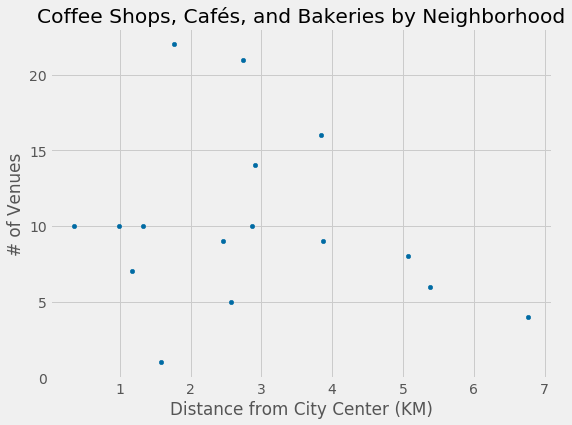

In [744]:
mpl.style.use('fivethirtyeight')
coffee_dist.plot(kind='scatter',x = 'Dist from center',y = 'Venue count',figsize=(8, 6))

plt.title('Coffee Shops, Cafés, and Bakeries by Neighborhood')
plt.ylabel('# of Venues')
plt.xlabel('Distance from City Center (KM)')


plt.show()

###Conclusion###
From this scatter plot we can see that the average number of venues tends to be around 10 venues per neighborhood. There are 4 neighborhoods that stand out above the average: Nørrebro, Trianglen, København N, and Nørreport. These 4 neighborhoods sit between about 1.7km and 3.9km from the city center. København N and Nørreport are densely populated hip areas with a lot of competition (the highest number of coffee related venues). But Nørrebro and Trianglen are still up and coming neighborhoods and may have room for growth. These two neighborhoods would be good places to scout for possible locations and get a feel for their potential. 

One other neighborhood, Kødbyen/Saxopark (also known as the former meatpacking district) has a slightly less than average number of coffee shops, just 9. But it is located within the 1.7-3.9km radius which the most popular neighborhoods are located in. In fact, the meatpacking district is one of the most popular areas in the city, housing a lot of bars, clubs, and restaurants as well as small businesses. It was one of the 5 city neighborhoods with 100+ venues and was clustered in cluster 1, making it more similar to the downtown neighborhoods. This is likely one of the best places to scout for a location as it appears to be overlooked by coffee shops and bakeries.

One final note is Fredriksholm/Nyholm neighborhood, shown on as the lowest # of venues on the scatter plot above, is a bit of an outlier. While the neighborhood is close to the city center it is located on an island with very few shops. It does have tourist attractions such as an opera house and some museums, but it is largely a sight seeing location and not a place with restaurants, cafes, or nightlife. This explains its unusually low number of venues.

Sources
https://www.citypopulation.de/php/denmark-admin.php?adm2id=147
https://www.citypopulation.de/php/denmark-copenhagen.php
https://en.wikipedia.org/wiki/Districts_of_Copenhagen